# Ejercicio para prácticar (Parte 1)

Sos un data scientist que trabaja para una empresa de publicidad que lanzo una campaña de publicidad en una red social. 
Se registró cada usuario al que se le mostró la publicidad, y se pudo obtener datos de la persona tales como 
`genero`, `edad` y `salario estimado`. Además, se registró si el usuario luego compró el producto que la publicidad 
hacía referencia. Los datos están en `Social_Network_Ads.csv`.
<br>
**Objetivo:** Se busca poder predecir dado un usuario con datos socioeconómicos si va a comprar o no el producto.

1. Realice un estudio de variables y de limpieza de datos. Analice las clases, están balanceadas, o no? ¿Qué clase 
nos parece más importante de las dos?
2. Separe el dataset en entrenamiento y validación.
3. Elija diferentes modelos de clasificación (al menos uno de regresión logística y uno de KNN). Elija las variables 
de entrada basándonos en el análisis del punto 1.
4. Compárelos con dos o más metrica de evaluación. ¿Cuál fue el mejor modelo? ¿Todas las métricas coincidieron o 
métricas diferentes evaluan como mejor a diferentes modelos? Discuta los resultados.
5. Para la regresión logística, cree una curva ROC para evaluar el modelo para ver la calidad del modelo, sin depender 
del valor umbral. Elija un valor umbral que considere más óptimo y vuelva a clasificar usando ese valor. ¿Cómo 
cambiaron las métricas usadas en el punto 4 con este valor umbral?
6. Utilizando alguna técnica de busqueda de hiper-parámetros, busque para el clasificador kNN los mejores parámetros. 
Se recomienda usar `n_neighbors`, `weights` y 'p', dejando el parámetro de distancia fijo como `'minkowski'`.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [105]:
df = pd.read_csv("datasets/Social_Network_Ads.csv")

1. Realice un estudio de variables y de limpieza de datos. Analice las clases, están balanceadas, o no? ¿Qué clase 
nos parece más importante de las dos?

In [106]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User ID          400 non-null    int64  
 1   Gender           400 non-null    object 
 2   Age              400 non-null    float64
 3   EstimatedSalary  400 non-null    float64
 4   Purchased        400 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 15.8+ KB


In [108]:
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [109]:
print("Valores nulos: ", df.isnull().sum())

print("\nValores duplicados: ", df.duplicated().sum())

Valores nulos:  User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

Valores duplicados:  0


In [110]:
# Se elimina la columna "User ID" ya que no aporta información relevante para el análisis
df = df.drop(columns=["User ID"])

In [111]:
target = "Purchased"
feature_names = [col for col in df.columns if col != target]
numeric_features = df[feature_names].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[feature_names].select_dtypes(include=['object', 'category']).columns.tolist()

target, feature_names, numeric_features, categorical_features

('Purchased',
 ['Gender', 'Age', 'EstimatedSalary'],
 ['Age', 'EstimatedSalary'],
 ['Gender'])

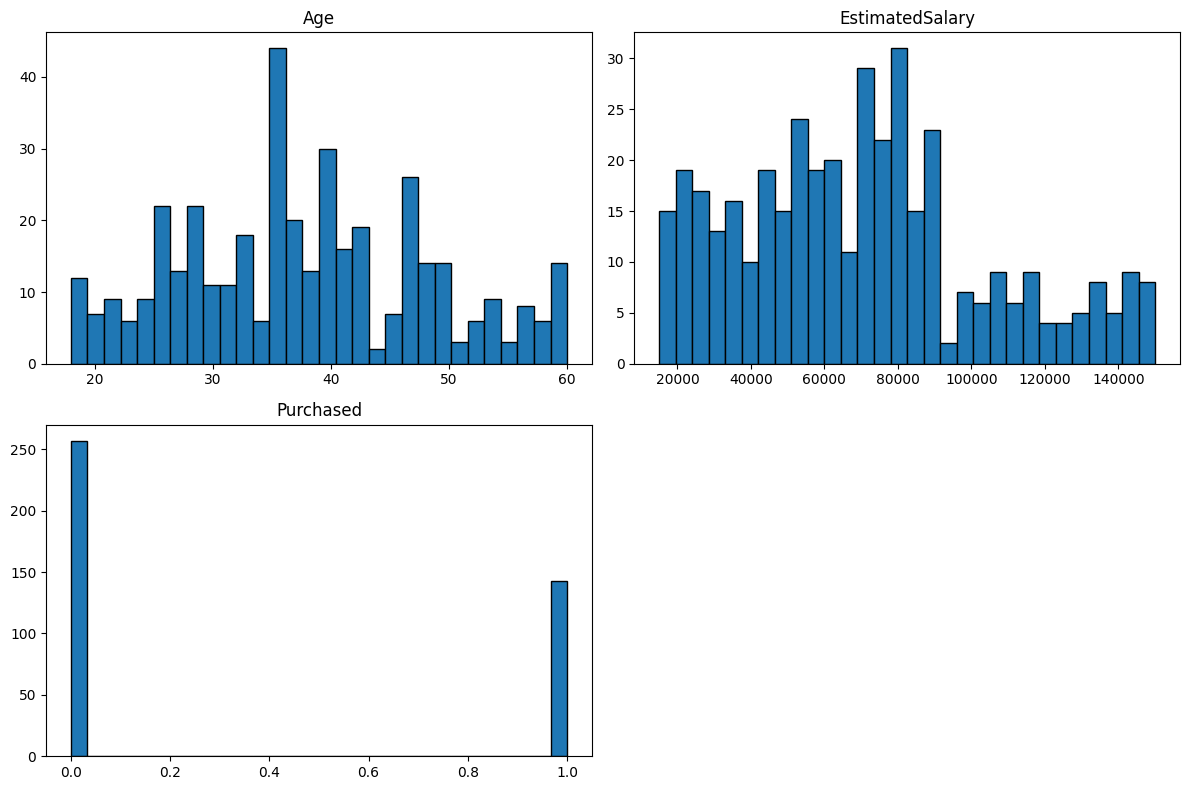

In [112]:
df.hist(bins=30, figsize=(12,8), edgecolor='black', grid=False)
plt.tight_layout()
plt.show()

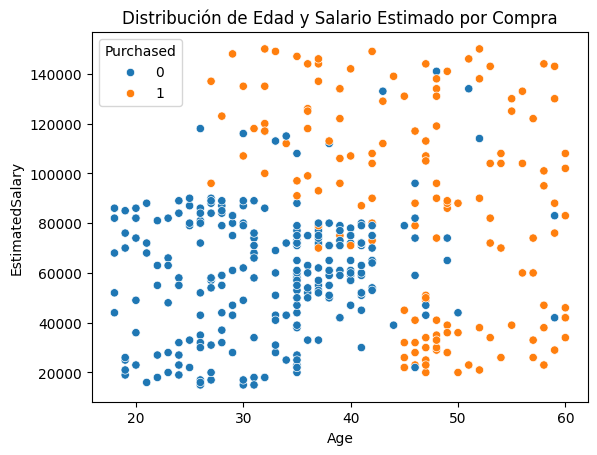

In [113]:
sns.scatterplot(data=df, x='Age', y='EstimatedSalary', hue='Purchased')
plt.title('Distribución de Edad y Salario Estimado por Compra')
plt.show()

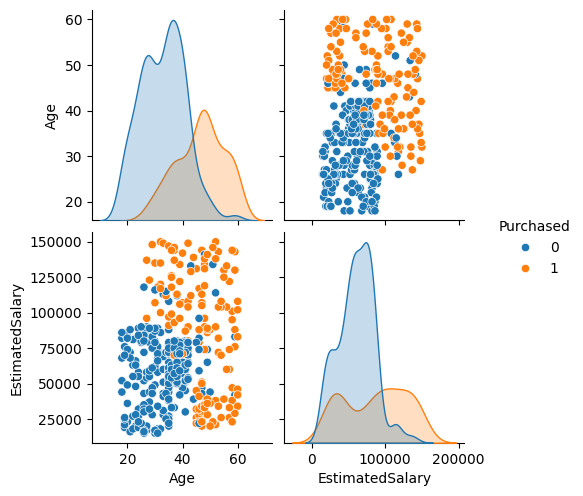

In [114]:
sns.pairplot(data=df, hue='Purchased', diag_kind="kde")
plt.show()

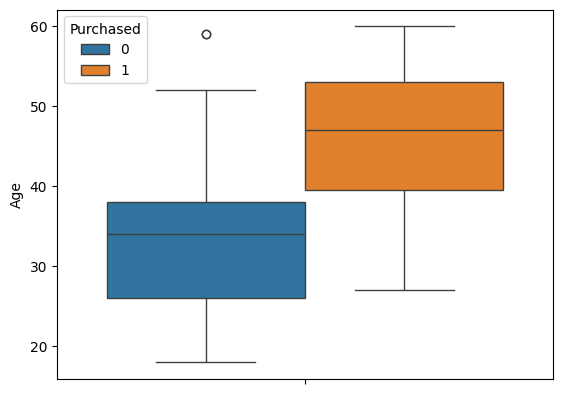

In [115]:
sns.boxplot(data=df, y='Age', hue='Purchased')
plt.show()

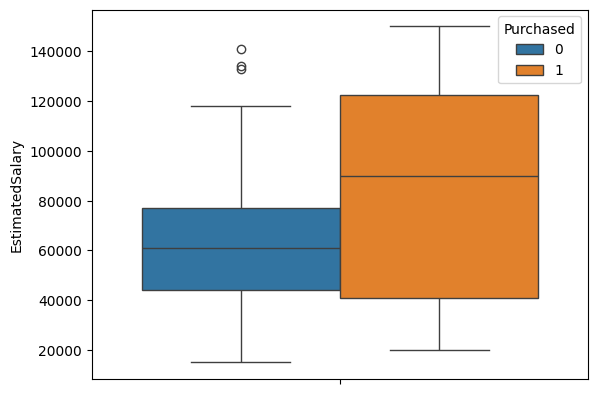

In [116]:
sns.boxplot(data=df, y="EstimatedSalary", hue="Purchased")
plt.show()

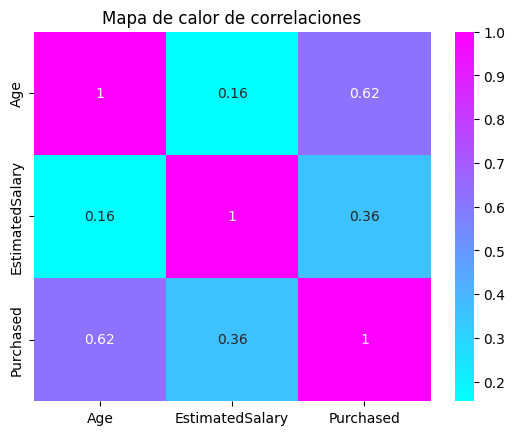

In [117]:
sns.heatmap(df[numeric_features+[target]].corr(), annot=True, cmap='cool')
plt.title('Mapa de calor de correlaciones')
plt.show()

In [118]:
print(f"Asímetría de la variable EstimatedSalary: {df['EstimatedSalary'].skew()}")
print(f"Curtosis de la variable EstimatedSalary: {df['EstimatedSalary'].kurtosis()}")

Asímetría de la variable EstimatedSalary: 0.49502362888993623
Curtosis de la variable EstimatedSalary: -0.4058775625580293


In [119]:
print(f"Asímetría de la variable Age: {df['Age'].skew()}")
print(f"Curtosis de la variable Age: {df['Age'].kurtosis()}")

Asímetría de la variable Age: 0.23133746309642822
Curtosis de la variable Age: -0.6225130156590515


Variables Categoricas

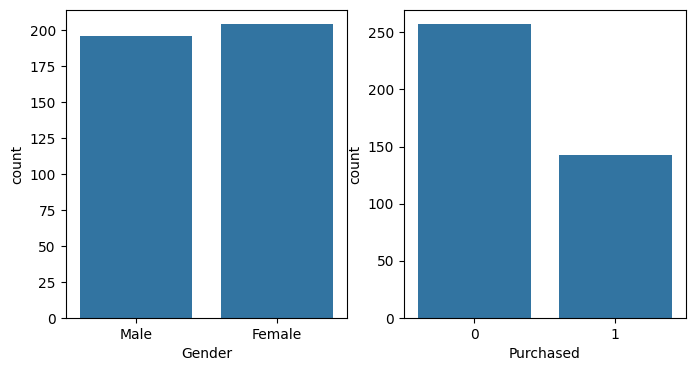

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Gráficos de barras de cada una
sns.countplot(x='Gender', data=df, ax=ax[0])
sns.countplot(x='Purchased', data=df, ax=ax[1])
plt.show()

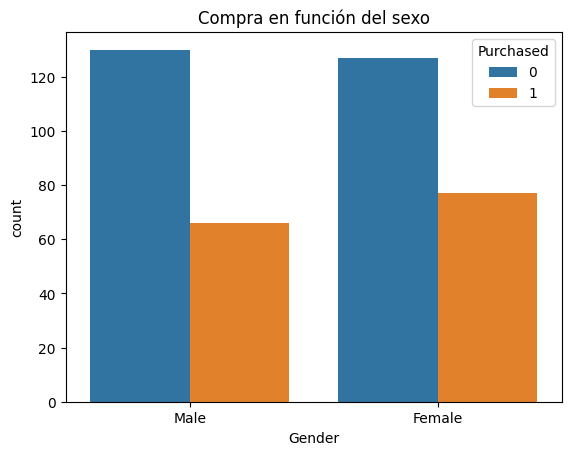

In [121]:
sns.countplot(x='Gender', hue='Purchased', data=df)
plt.title("Compra en función del sexo")
plt.show()

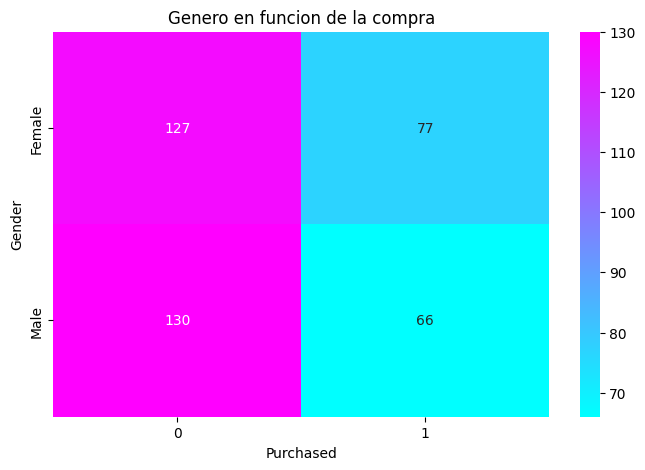

In [122]:
plt.figure(figsize=(8, 5))
cross_tab = pd.crosstab(df['Gender'], df[target])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='cool')
plt.title('Genero en funcion de la compra')
plt.show()

In [123]:
print(pd.crosstab(df["Gender"], df["Purchased"], normalize="index"))

Purchased         0         1
Gender                       
Female     0.622549  0.377451
Male       0.663265  0.336735


Del analisis podemos ver que la variable numerica que mas influye es la edad. Del genero, no hay una diferencia significativa en la compra del producto (no aporta valor). Por lo tanto, se usara la edad y el salario como entradas al modelo.

Por otra parte, del target la clase 1 es la mas importante, porque queremos identificar a los potenciales clientes que sí comprarían el producto. Ademas existe un desbalance en las clases, siendo la clase 0 la mas frecuente. Por lo tanto el accurracy no es una buena metrica a considerar por si sola

2. Separe el dataset en entrenamiento y validación.

In [124]:
X = df[feature_names]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((280, 3), (120, 3), (280,), (120,))

In [125]:
scaler = StandardScaler() # MinMaxScaler()

# Entrenamos el escalador solo con el set de entrenamiento
X_train_scaled = scaler.fit_transform(X_train[["Age", "EstimatedSalary"]])
# Y transformamos el set de testeo
X_test_scaled = scaler.transform(X_test[["Age", "EstimatedSalary"]])

3. Elija diferentes modelos de clasificación (al menos uno de regresión logística y uno de KNN). Elija las variables 
de entrada basándonos en el análisis del punto 1.

In [126]:
log_model = LogisticRegression(class_weight="balanced") # Se balancea los pesos del target
knn_model = KNeighborsClassifier()

log_model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [127]:
knn_model.fit(X_train_scaled, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


4. Compárelos con dos o más metrica de evaluación. ¿Cuál fue el mejor modelo? ¿Todas las métricas coincidieron o 
métricas diferentes evaluan como mejor a diferentes modelos? Discuta los resultados.

In [128]:
y_pred_log = log_model.predict(X_test_scaled)
y_pred_knn = knn_model.predict(X_test_scaled)

In [129]:
print("📊 Reporte de clasificación Regresion Logistica")
print(classification_report(y_test, y_pred_log, digits=3))

📊 Reporte de clasificación Regresion Logistica
              precision    recall  f1-score   support

           0      0.887     0.818     0.851        77
           1      0.714     0.814     0.761        43

    accuracy                          0.817       120
   macro avg      0.801     0.816     0.806       120
weighted avg      0.825     0.817     0.819       120



In [130]:
print("📊 Reporte de clasificación KNN")
print(classification_report(y_test, y_pred_knn, digits=3))

📊 Reporte de clasificación KNN
              precision    recall  f1-score   support

           0      0.935     0.935     0.935        77
           1      0.884     0.884     0.884        43

    accuracy                          0.917       120
   macro avg      0.909     0.909     0.909       120
weighted avg      0.917     0.917     0.917       120



📊 Matriz de confusión


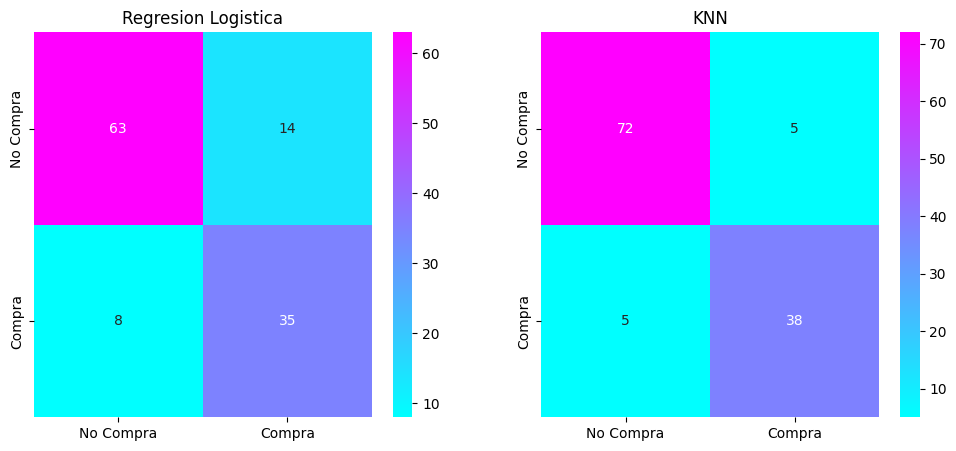

In [131]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

print("📊 Matriz de confusión")
cm_log = confusion_matrix(y_test, y_pred_log)
cm_knn = confusion_matrix(y_test, y_pred_knn)

sns.heatmap(cm_log, annot=True, fmt="d", cmap="cool",
            xticklabels=["No Compra", "Compra"],
            yticklabels=["No Compra", "Compra"], ax=ax[0])
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="cool",
            xticklabels=["No Compra", "Compra"],
            yticklabels=["No Compra", "Compra"], ax=ax[1])

ax[0].set_title("Regresion Logistica")
ax[1].set_title("KNN")
plt.show()

Comparando los modelos de Regresion Logistica y KNN, podemos ver que el modelo KNN tiene un mejor rendimiento en todas las metricas evaluadas (precision, recall y f1-score) para ambas clases.

5. Para la regresión logística, cree una curva ROC para evaluar el modelo para ver la calidad del modelo, sin depender 
del valor umbral. Elija un valor umbral que considere más óptimo y vuelva a clasificar usando ese valor. ¿Cómo 
cambiaron las métricas usadas en el punto 4 con este valor umbral?

In [132]:
from sklearn.metrics import roc_curve, roc_auc_score
# Curva ROC para el modelo de Regresión Logística
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]

auc = roc_auc_score(y_test, y_proba_log)
print(f"AUC-ROC: {auc:.3f}")

AUC-ROC: 0.918


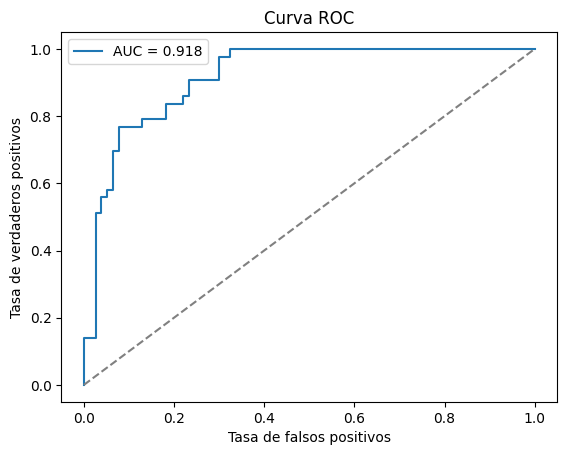

In [133]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba_log)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()

In [134]:
# Calcular Youden’s J
J = tpr - fpr
best_idx = np.argmax(J)
best_threshold = thresholds[best_idx]

print(f"Mejor umbral segun Youden's J: {best_threshold:.2f}")
print(f"TPR (Recall): {tpr[best_idx]:.3f}, FPR: {fpr[best_idx]:.3f}")

Mejor umbral segun Youden's J: 0.59
TPR (Recall): 0.767, FPR: 0.078


In [135]:
y_pred_threshold = (y_proba_log >= 0.4).astype(int)

print("📊 Reporte de clasificación Regresion Logistica")
print(classification_report(y_test, y_pred_threshold, digits=3))

📊 Reporte de clasificación Regresion Logistica
              precision    recall  f1-score   support

           0      0.935     0.753     0.835        77
           1      0.672     0.907     0.772        43

    accuracy                          0.808       120
   macro avg      0.804     0.830     0.803       120
weighted avg      0.841     0.808     0.812       120



Si se quiere captar mas compradores potenciales, se elige un umbral=0.4. De las metricas vemos que mejora el recall pero disminuye la presicion (lo cual es esperado)

6. Utilizando alguna técnica de busqueda de hiper-parámetros, busque para el clasificador kNN los mejores parámetros. 
Se recomienda usar `n_neighbors`, `weights` y 'p', dejando el parámetro de distancia fijo como `'minkowski'`.

In [136]:
from sklearn.model_selection import GridSearchCV

classifier_knn = KNeighborsClassifier()

hyperparams = {"n_neighbors": np.arange(1, 31),     # Cantidad de vecinos.
               "weights": ["uniform", "distance"],  # Como se pesa los votos
               "p": np.arange(1.0, 31.0)}           # Valores para la distancia de Minkowski

# Creamos un método de busqueda por grilla:
grid = GridSearchCV(estimator=classifier_knn,
                    param_grid=hyperparams,
                    refit=False,
                    cv=3,
                    scoring='f1',
                    n_jobs=-1)

grid.fit(X_train_scaled, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': array([ 1, 2..., 28, 29, 30]), 'p': array([ 1., ...8., 29., 30.]), 'weights': ['uniform', 'distance']}"
,scoring,'f1'
,n_jobs,-1
,refit,False
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,5


In [137]:
# Veamos los mejores parámetros encontrados:
print(f"Mejores parámetros: {grid.best_params_}")

Mejores parámetros: {'n_neighbors': np.int64(3), 'p': np.float64(1.0), 'weights': 'uniform'}


In [138]:
# Evaluemos y entrenemos al mejor modelo encontrado:
best_knn_grid = KNeighborsClassifier(**grid.best_params_)
best_knn_grid.fit(X_train_scaled, y_train)

,n_neighbors,np.int64(3)
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,np.float64(1.0)
,metric,'minkowski'
,metric_params,None
,n_jobs,None


📊 Reporte de clasificación KNN
              precision    recall  f1-score   support

           0      0.912     0.948     0.930        77
           1      0.900     0.837     0.867        43

    accuracy                          0.908       120
   macro avg      0.906     0.893     0.899       120
weighted avg      0.908     0.908     0.908       120

📊 Matriz de confusión


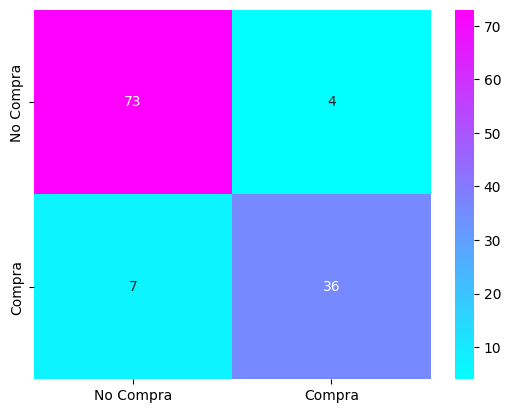

In [139]:
y_pred_knn_best = best_knn_grid.predict(X_test_scaled)

print("📊 Reporte de clasificación KNN")
print(classification_report(y_test, y_pred_knn_best, digits=3))

print("📊 Matriz de confusión")
cm_log_best = confusion_matrix(y_test, y_pred_knn_best)

sns.heatmap(cm_log_best, annot=True, fmt="d", cmap="cool",
            xticklabels=["No Compra", "Compra"],
            yticklabels=["No Compra", "Compra"])

plt.show()

En base a los mejores parametros, dados por GridSearch, el modelo de KNN mejora un poco

# Ejercicio para prácticar (Parte 2)

2. Continuando con el ejercicio de la clase 2 del dataset `Social_Network_Ads.csv`. Incorpore al estudio de los modelos 
al menos un SVM de clasificación y repita las evaluaciones que se hicieron con los clasificadores. Discuta los 
resultados obtenidos.

In [140]:
from sklearn.svm import SVC

svc = SVC(C=10)

svc.fit(X_train_scaled, y_train)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


📊 Reporte de clasificación SVC
              precision    recall  f1-score   support

           0      0.935     0.935     0.935        77
           1      0.884     0.884     0.884        43

    accuracy                          0.917       120
   macro avg      0.909     0.909     0.909       120
weighted avg      0.917     0.917     0.917       120

📊 Matriz de confusión SVC


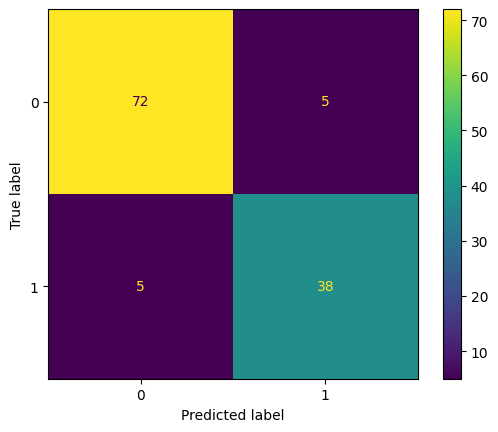

In [141]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_svc = svc.predict(X_test_scaled)

print("📊 Reporte de clasificación SVC")
print(classification_report(y_test, y_pred_svc, digits=3))

print("📊 Matriz de confusión SVC")
cm_svc = confusion_matrix(y_test, y_pred_svc, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=svc.classes_)

disp.plot();

📝 SVC no introdujo una mejora significativa, performa casi igual que el mejor KNN